In [1]:
%load_ext autoreload
%autoreload 2

import sklearn.metrics as metrics
from utils.temperature_scaling import ModelWithTemperature
from matplotlib import pyplot as plt
import utils.visualisations
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms

import utils.metrics
import utils.model

import models.resnet_dropout
import models.resnet

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("cpu")
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 2070 SUPER
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [6]:
class VOCTransform(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, labels):
        labels = (labels * 255).squeeze(0).to(torch.long)
        labels[labels == 255] = 0
        return labels


transforms_normalized = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    VOCTransform()
])


data_train = torchvision.datasets.VOCSegmentation(
    root="VOC", download=True, image_set="train", transform=transforms_normalized, target_transform=target_transforms)
data_loader_train = torch.utils.data.DataLoader(data_train,
                                          batch_size=64,
                                          shuffle=False)



data_test = torchvision.datasets.VOCSegmentation(
    root="VOC", download=True, image_set="val", transform=transforms_normalized, target_transform=target_transforms)
data_loader_test = torch.utils.data.DataLoader(data_test,
                                          batch_size=64,
                                          shuffle=False)

dataset_sizes = {"train": len(data_train), "val": len(data_test)}
data_loaders = {"train": data_loader_train, "val": data_loader_test}

Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC


In [7]:
VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "dining table",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]

def decode_segmap(image, nc=22):
    label_colors = np.array([(0, 0, 0),  # 0=background
                             # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
                             (128, 0, 0), (0, 128, 0), (128, 128,
                                                        0), (0, 0, 128), (128, 0, 128),
                             # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
                             (0, 128, 128), (128, 128, 128), (64,
                                                              0, 0), (192, 0, 0), (64, 128, 0),
                             # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
                             (192, 128, 0), (64, 0, 128), (192, 0,
                                                           128), (64, 128, 128), (192, 128, 128),
                             # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
                             (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128), (128, 128, 128)])
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [4]:

model = torch.load("models/VOC_segmentation_deeplabv3_mobilenet_v3_large")

In [5]:
model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1),

In [6]:
model = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(
    pretrained=False)
# utils.mc_dropout.set_dropout_p(model, model, .25)
print(model)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1),

In [7]:
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1),

In [9]:
from tqdm import tqdm
import torchmetrics  


def train_model(model, num_epochs, optimizer, criterion, data_loaders, device):
    softmax = nn.Softmax(dim=1)
    precision_holder = []
    model.to(device)
    for epoch in range(num_epochs):
        precision_holder.append({
            "train": utils.metrics.Progress(),
            "val": utils.metrics.Progress()
        })
        print(f'Epoch {epoch+1}/{num_epochs}', flush=True)
        print('-' * 10, flush=True)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            running_entropy = 0.0
            running_maxes = 0.0
            numel = 0
            count = 0
            progress_bar = tqdm(data_loaders[phase])
            for inputs, labels in progress_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                numel += labels.numel()
                current_holder = precision_holder[epoch][phase]
                optimizer.zero_grad()
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)["out"]
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                probs = softmax(outputs).detach()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_maxes += torch.sum(torch.max(probs, dim=1)[0])
                current_holder = current_holder.update(
                    preds.cpu(), labels.cpu(), probs.cpu(), outputs.detach().cpu())

                epoch_loss = loss.item()
                iou = torchmetrics.functional.jaccard_index(preds, labels).item()
                dice = torchmetrics.functional.dice_score(preds, labels).item()
                epoch_acc = running_corrects.double() / numel
                # epoch_entropy = running_entropy / count
                epoch_avg_max = running_maxes / count
                progress_str = f'{phase} Loss: {epoch_loss:.2f} Acc: {epoch_acc:.2f} IOU: {iou:.2f} DICE: {dice:.2f} Avg. max. prob: {epoch_avg_max:.2f}'
                progress_bar.set_description(progress_str)
    return precision_holder

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
train_progress = train_model(
    model, 50, optimizer, criterion, data_loaders, device)

Epoch 1/50
----------


train Loss: 1.04 Acc: 0.72 IOU: 0.23 DICE: 0.02 Avg. max. prob: inf: 100%|██████████| 23/23 [00:57<00:00,  2.48s/it]
val Loss: 1.17 Acc: 0.71 IOU: 0.20 DICE: 0.02 Avg. max. prob: inf: 100%|██████████| 23/23 [00:32<00:00,  1.41s/it]

Epoch 2/50
----------



train Loss: 0.68 Acc: 0.81 IOU: 0.33 DICE: 0.04 Avg. max. prob: inf: 100%|██████████| 23/23 [00:41<00:00,  1.83s/it]
val Loss: 0.74 Acc: 0.78 IOU: 0.23 DICE: 0.02 Avg. max. prob: inf: 100%|██████████| 23/23 [00:33<00:00,  1.45s/it]

Epoch 3/50
----------



train Loss: 0.50 Acc: 0.85 IOU: 0.44 DICE: 0.05 Avg. max. prob: inf:  22%|██▏       | 5/23 [00:11<00:42,  2.34s/it]

In [12]:
def set_dropout_p(model, block, prob, omitted_blocks=[]):
    for name, p in block.named_children():
        if any(map(lambda x: isinstance(p, x), omitted_blocks)):
            continue
        if isinstance(p, torch.nn.Module):
            set_dropout_p(model, p, prob, omitted_blocks)
        if isinstance(p, torch.nn.ReLU):
            setattr(block, name, torch.nn.Sequential(torch.nn.ReLU(), torch.nn.Dropout2d(p=prob)))
            return model

set_dropout_p(model, model, 0.05)
model.classifier[3]=torch.nn.ReLU()
model.aux_classifier[2]=torch.nn.ReLU()

In [17]:
model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Sequential(
            (0): ReLU()
            (1): Dropout2d(p=0.05, inplace=False)
          )
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvN

In [6]:
from utils.temperature_scaling import ModelWithTemperature
scaled_model = ModelWithTemperature(model)
scaled_model.temperature = torch.nn.Parameter(torch.tensor(1.458))
# scaled_model.set_temperature(data_loader, device)

In [8]:
from tqdm import tqdm
import torchmetrics  
from typing import OrderedDict

def run_validation(model, data_loader, test_progress: utils.metrics.Progress, device, mc_dropout_iters=0):
    softmax = nn.Softmax(dim=1)
    progress_bar = tqdm(data_loader)
    count = 0
    running_corrects = 0
    model = model.to(device)
    softmax = torch.nn.Softmax(dim=1)
    for inputs, labels in progress_bar:
        # labels = (labels * 255).squeeze().to(torch.uint8)
        # labels[labels == 255] = 21
        inputs = inputs.to(device)
        count += labels.numel()
        model.eval()
        with torch.no_grad():
            logits = model(inputs)
        if isinstance(logits, OrderedDict):
            logits = logits["out"]    
        logits = logits.cpu()
        probs = softmax(logits)
        max_probs, preds = torch.max(probs, 1)
        running_corrects += np.count_nonzero(preds == labels.squeeze(1))
        # print(torchmetrics.functional.iou(
        # preds, labels, ignore_index=21, num_classes=22))
        if mc_dropout_iters > 0:
            mc_means, mc_vars = utils.mc_dropout.mc_dropout(
                model, inputs, logits.shape[1:], T=mc_dropout_iters)
            # batch_nll = - utils.mc_dropout.compute_log_likelihood(
            #     mc_means, torch.nn.functional.one_hot(labels, num_classes=mc_means.shape[-1]), torch.sqrt(mc_vars))
            batch_nll = torch.tensor([0])
            mc_predictions = mc_means.argmax(axis=1)
            test_progress.dropout_outputs.append(mc_means.numpy())
            test_progress.dropout_predictions = np.append(
                test_progress.dropout_predictions, mc_predictions)
            test_progress.dropout_variances = np.append(
                test_progress.dropout_variances, mc_vars)

        test_progress.update(preds, labels, probs, logits)
        progress_bar.set_description(
            f"Avg. acc.: {100*running_corrects/count:.2f}")

    test_progress.predictions = np.concatenate(test_progress.predictions)
    test_progress.logits = np.concatenate(test_progress.logits)
    test_progress.probs = np.concatenate(test_progress.probs)
    if mc_dropout_iters > 0:
        test_progress.dropout_outputs = np.concatenate(
            test_progress.dropout_outputs)
    return test_progress

progress = run_validation(
    model, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=0)

# progress_scaled = run_validation(
#     scaled_model, data_loader, utils.metrics.Progress(), device, mc_dropout_iters=0)    

Avg. acc.: 84.66: 100%|██████████| 23/23 [00:30<00:00,  1.31s/it]


In [9]:
preds = torch.Tensor(progress.predictions).to(torch.uint8)
labels = torch.Tensor(progress.labels.reshape(progress.predictions.shape)).to(torch.uint8)

print(torchmetrics.functional.jaccard_index(preds, labels))
# print(torchmetrics.functional.dice_score(preds, labels, ignore_index=21, num_classes=22))


tensor(0.5036)


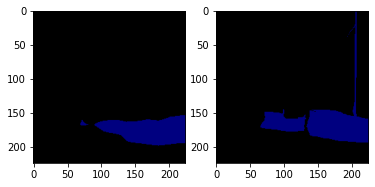

In [10]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(decode_segmap(progress.predictions[2]))
axs[1].imshow(decode_segmap(labels[2]))

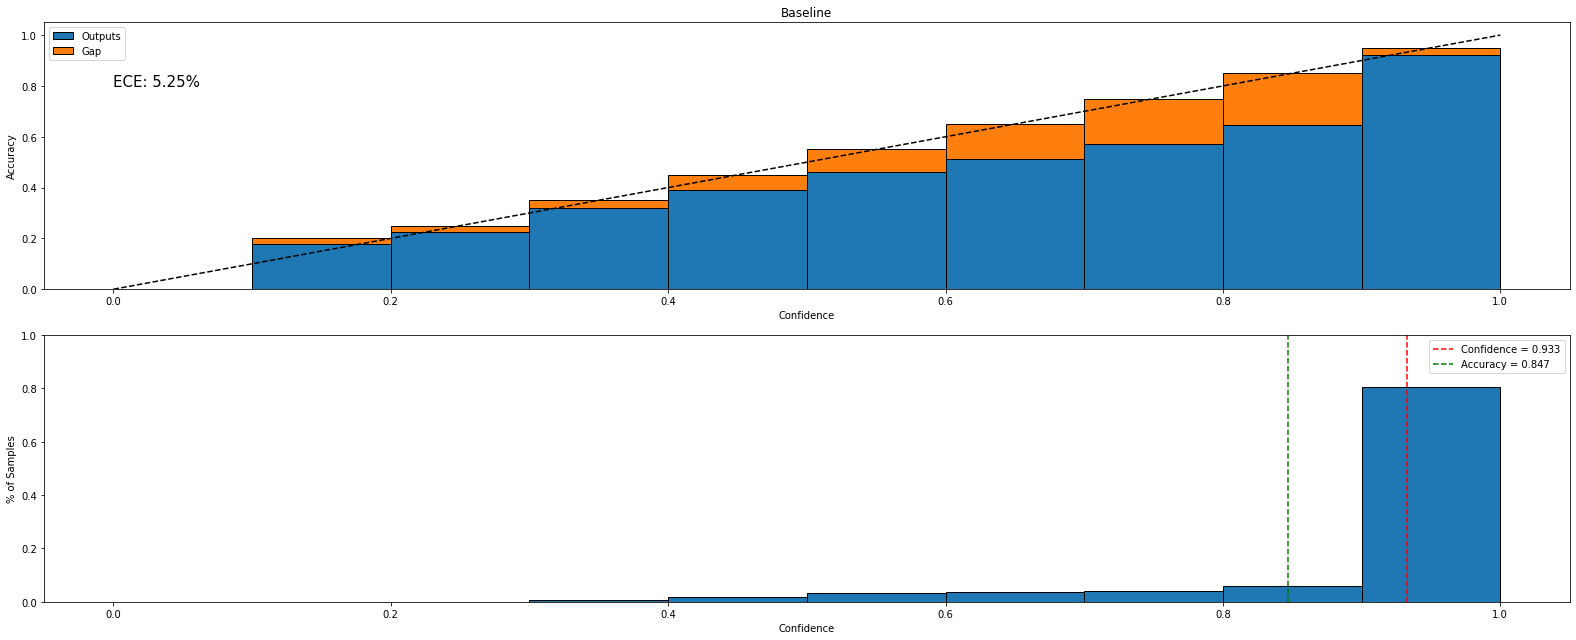

In [11]:
# nll = nn.CrossEntropyLoss()(torch.tensor(progress.logits), torch.tensor(
#     progress.labels, dtype=torch.long)).item()
# print(
#     f"Accuracy: {(progress.predictions==progress.labels).sum()*100/len(progress.labels):.2f}%, "
#     f"NLL: {nll:4f}"
# )

# # mc_logits = progress.dropout_logits.mean(axis=0)
# dropout_max_probs = progress.dropout_outputs.max(axis=-1)

# utils.visualisations.samples_removed_vs_acc([
#     ("Max prob", np.argsort(progress.max_probs)),
#     ("Dropout max probs", np.argsort(dropout_max_probs))],
#     progress.labels,
#     progress.predictions,
#     progress.dropout_predictions)

# dropout_max_probs = progress.dropout_outputs.max(axis=1).ravel()

utils.visualisations.calibration_graph([
        ("Baseline", progress.max_probs, np.argsort(progress.max_probs), progress.predictions.ravel()),
        # ("MCD", dropout_max_probs, np.argsort(dropout_max_probs), progress.dropout_outputs.argmax(axis=1).ravel()),
        # ("Temp scaling", progress_scaled.max_probs, np.argsort(progress_scaled.max_probs), progress_scaled.predictions.ravel()),


    ],
    progress.labels,
    )

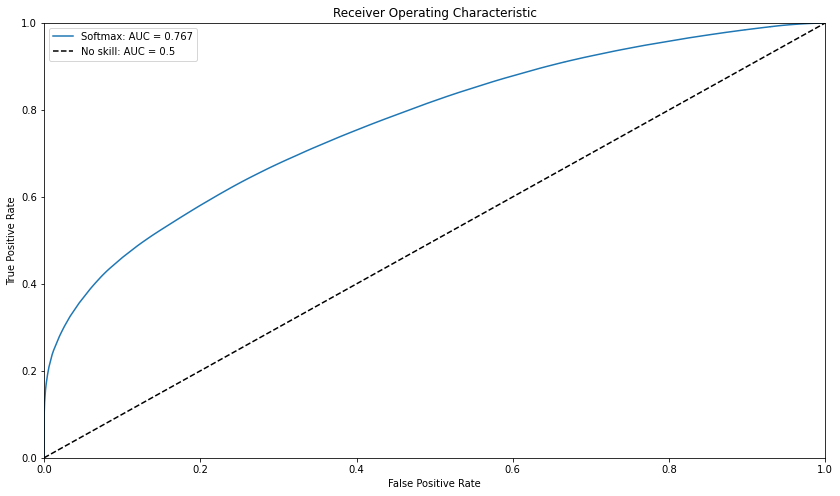

In [9]:
curves = []

correct = progress.predictions.ravel() == progress.labels.ravel()
fpr, tpr, _ = metrics.roc_curve(correct, progress.max_probs)
roc_auc = metrics.auc(fpr, tpr)

prec, recall, _ = metrics.precision_recall_curve(correct, progress.max_probs)
aupr = metrics.auc(recall, prec)
curves.append({
    "fpr": fpr,
    "tpr": tpr,
    "auroc": roc_auc,
    "prec": prec,
    "recall": recall,
    "aupr": aupr,
    "label": "Softmax"
})

# correct = progress.dropout_predictions == progress.labels
# dropout_max_probs = progress.dropout_outputs.max(axis=-1)
# fpr, tpr, _ = metrics.roc_curve(correct, dropout_max_probs)
# roc_auc = metrics.auc(fpr, tpr)

# prec, recall, _ = metrics.precision_recall_curve(correct, dropout_max_probs)
# aupr = metrics.auc(recall, prec)

# curves.append({
#     "fpr": fpr,
#     "tpr": tpr,
#     "auroc": roc_auc,
#     "prec": prec,
#     "recall": recall,
#     "aupr": aupr,
#     "label": "MC Dropout"
# })


plt.figure(figsize=(14, 8))
plt.title('Receiver Operating Characteristic')
for curve in curves:
    plt.plot(curve["fpr"], curve["tpr"],
             label=f"{curve['label']}: AUC = {curve['auroc']:.3f}")
plt.plot([0, 1], [0, 1], 'k--', label=f"No skill: AUC = 0.5")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

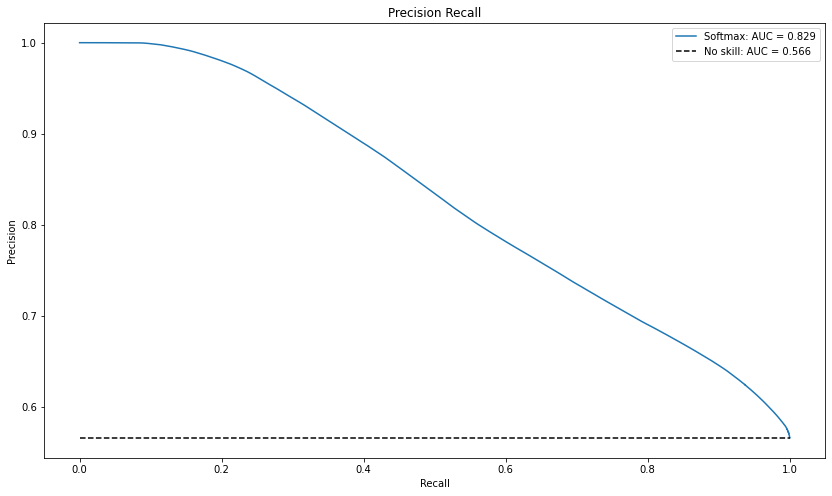

In [10]:
no_skill = correct.sum() / len(correct)
plt.figure(figsize=(14, 8))
plt.title('Precision Recall')
for curve in curves:
    plt.plot(curve["recall"], curve["prec"],
             label=f"{curve['label']}: AUC = {curve['aupr']:.3f}")
# axis labels
plt.plot([0, 1], [no_skill, no_skill], color="k",
         linestyle='--', label=f'No skill: AUC = {no_skill:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()